# Lab 3

## Question 1

Claude Shannon's paper begins with the idea that the problem of communication is merely reproducing a message at one point from another point. The messages’ meaning or lack thereof is irrelevant to the engineering problem of communication. Shannon then states that systems allowing communication to occur generally consist of five essential parts. The information source that produces the message, the transmitter which transforms the message, the channel which carries the transformed message, the receiver which performs the inverse of the transformation done by the transmitter, and finally a destination where the message is delivered. Shannon goes on to further discuss about the communication system model starting with the channel, specifically what a channel’s maximum capacity is. Afterwards, he gives examples of information sources leading to showing that information sources can be modeled as Markov processes. Following the discussion of information sources, Shannon talks about the entropy or uncertainty that choice brings in an information source and how through considering the statistical structure of that information we can reduce the entropy. This reduction of entropy from a maximum entropy value given the same set of symbols is the redundancy in the information source. As a final topic, he briefly discusses the encoding and decoding of information to get the entropy of the source, before stating that it isn’t possible to communicate at an average rate greater than C/H (symbols per second) where C is the capacity of the channel (bits per second) and H is the entropy of the source (bits per symbol).

## Question 2

ICML is a top research conference in Machine learning.  Scrape all the pdfs of all ICML 2017 papers from http://proceedings.mlr.press/v70/.

In [121]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
import wget


def collect_pdfs():
    base_url = 'http://proceedings.mlr.press/v70/'
    html = urlopen(base_url).read()
    html_page = bs(html) 
    
    collected = []
    
    for link in html_page.find_all('a'):
        if link.get('href').endswith('pdf') and not link.get('href').endswith('-supp.pdf'):
            try:
                filename = './pdfs/' + link.get('href').split('/')[-1]
                wget.download(link.get('href'), out=filename)
                collected.append(filename)
            except:
                print('Could not download ', link.get('href'))
    
    return collected

In [122]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def pdf_to_text(filename):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    
    with open(filename, 'rb') as pdf:
        for page in PDFPage.get_pages(pdf):
            interpreter.process_page(page)

    text = retstr.getvalue()
    device.close()
    retstr.close()
    return text

In [123]:
files = collect_pdfs()

In [ ]:
# write out all the pdf content into a text file
# avoids having to do this multiple times
    
for pdf in files:
    filename = "./converted_pdfs/" + pdf.split('/')[-1].split('.')[0] + ".txt"
    with open(filename, 'w') as txt_file:
        text = pdf_to_text(pdf)
        txt_file.write(text)

1. What are the top 10 common words in the ICML papers?

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import os

vectorizer = CountVectorizer()
training_words = []

for file in os.listdir(os.path.join(os.getcwd(), './converted_pdfs/')):
    with open('./converted_pdfs/' + file) as f:
        training_words.append(f.read())

c = Counter('\n'.join(training_words).lower().split())
print(len(training_words))

434


In [20]:
counts = {k:v for k, v in sorted(c.items(), key=lambda x: x[1], reverse=True) if k.isalpha() and len(k) > 1}

In [21]:
top10 = dict(sorted(counts.items(), key=lambda x: x[1], reverse = True)[:10])
print(top10)

{'the': 149642, 'of': 75243, 'and': 65395, 'in': 51945, 'to': 49276, 'is': 39665, 'for': 36478, 'we': 33957, 'that': 24193, 'with': 21569}


2.  Let Z be a randomly selected word in a randomly selected ICML paper.  Estimate the entropy of Z.

In [28]:
import numpy as np

entropy = 0
for paper in training_words:
    paper_counter = Counter([x.lower() for x in paper.split() if x.isalpha() and len(x) > 1])
    total_observed = sum(v for _,v in paper_counter.items())
    if total_observed == 0:
        continue
    for _, obs in counts.items():
        prob = (obs/total_observed) * (1/len(training_words)) # probability conditioned on each paper
        entropy += prob * np.log2(prob)
entropy = -entropy
print(entropy)

2865.5581445032108


3.  Synthesize a random paragraph using the marginal distribution over words.

In [50]:
probabilities = []
for word, obs in counts.items():
    probabilities.extend([word] * obs)


total_words = sum(occ for _, occ in counts.items())
paragraph = []
for i in range(100):
    num = np.random.uniform(0, total_words)
    paragraph.append(probabilities[int(num)])

print(' '.join(paragraph))

will size experiments decrease illustration by the some gradient through educational notes variety line the with decompose coherent are convergence noteworthy minimization the learning is marginal matrix of further this extend if we decoupled known view et is optimal neural statistical for and ment total with to reward chooses wi the experimental mean teacher local the is initialization second cost assigned henao respect is used each of extremely the of predict ddr the set log propose their while by carpentier to of nk in we and validation uncertainty satisfy in which regards it the for while false hamming of ﬁve


## Question 3

here


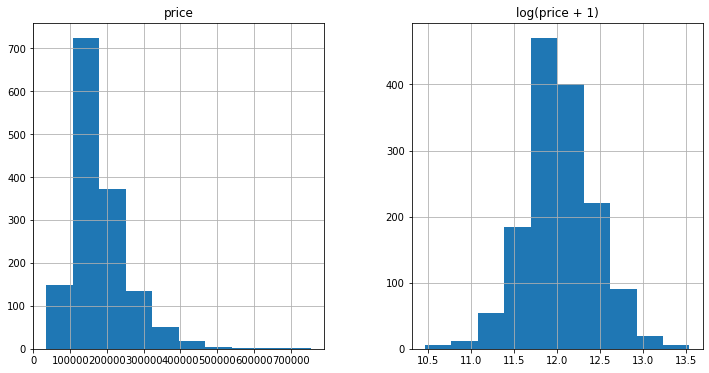

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%matplotlib inline
train = pd.read_csv('./kaggle/train.csv')
test = pd.read_csv('./kaggle/test.csv')

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

print('here')

In [4]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [6]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [7]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [8]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train, y)

results = np.expm1(model_ridge.predict(X_test))
results_df = pd.DataFrame(results)
results_df.columns = ['SalePrice']

results_df.index += 1461
results_df.index.name = 'Id'

results_df.to_csv('./kaggle/results.csv')

Simple Ridge submission results:

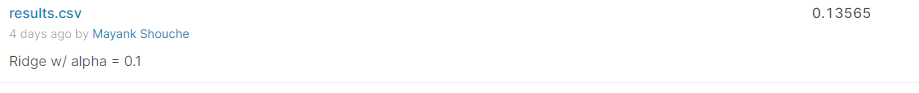

Compare a ridge regression and a lasso regression model.  
Optimize the alphas using crossvalidation.  
What is the best score you can get from a single ridge regression model and froma single lasso model?

Text(0, 0.5, 'rmse')

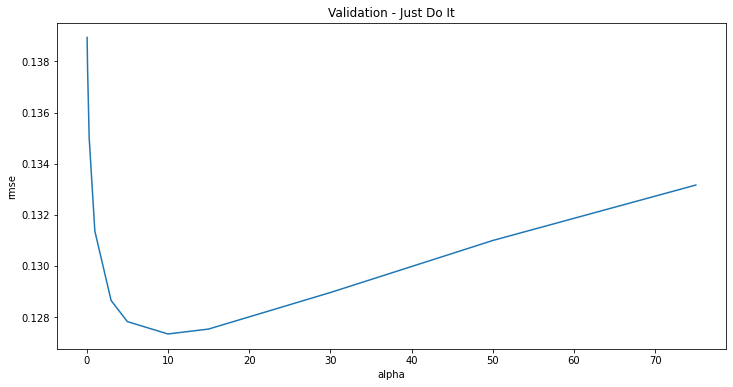

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    # gets the rmse using cross validation as a metric
    # cross validation is a means of measuring performance
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()


alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [11]:
best_cv_ridge = cv_ridge.min()

# from the graph above, an alpha of 10 minimizes RMSE
optimal_ridge = Ridge(alpha=10)
optimal_ridge.fit(X_train, y)

results_ridge = np.expm1(optimal_ridge.predict(X_test))
results_ridge_df = pd.DataFrame(results_ridge)
results_ridge_df.columns = ['SalePrice']

results_ridge_df.index += 1461
results_ridge_df.index.name = 'Id'

results_ridge_df.to_csv('./kaggle/results_ridge.csv')


Text(0, 0.5, 'rmse')

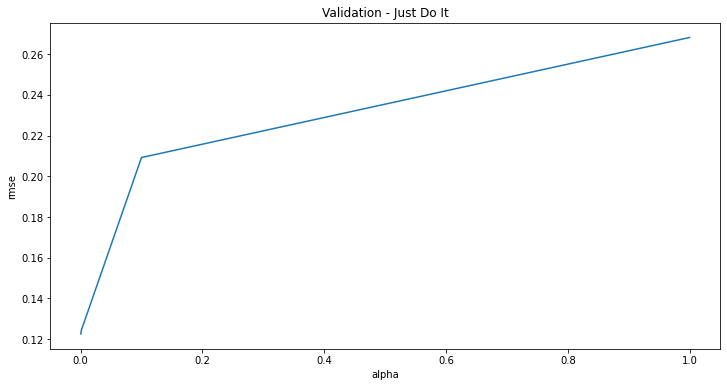

In [12]:
alph =  [1, 0.1, 0.001, 0.0005]
cv_lasso = [rmse_cv(Lasso(alpha=alpha)).mean() for alpha in alph]
cv_lasso = pd.Series(cv_lasso, index=alph)
cv_lasso.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [13]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
best_cv_lasso = rmse_cv(model_lasso).mean()

results_lasso = np.expm1(model_lasso.predict(X_test))
results_lasso_df = pd.DataFrame(results_lasso)
results_lasso_df.columns = ['SalePrice']

results_lasso_df.index += 1461
results_lasso_df.index.name = 'Id'

results_lasso_df.to_csv('./kaggle/results_lasso.csv')


Scores from the best Ridge and Lasso models:
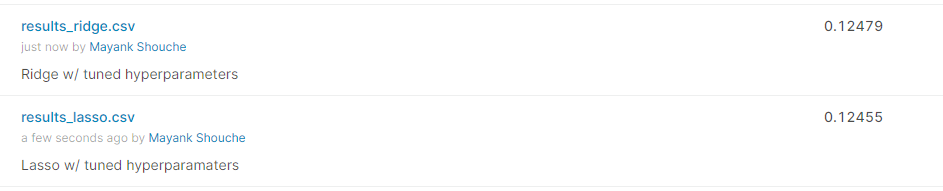

It appears that lasso gets a slightly better score than ridge.

Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary thestrength of regularization parameter alpha.

Text(0, 0.5, 'l0 Norm')

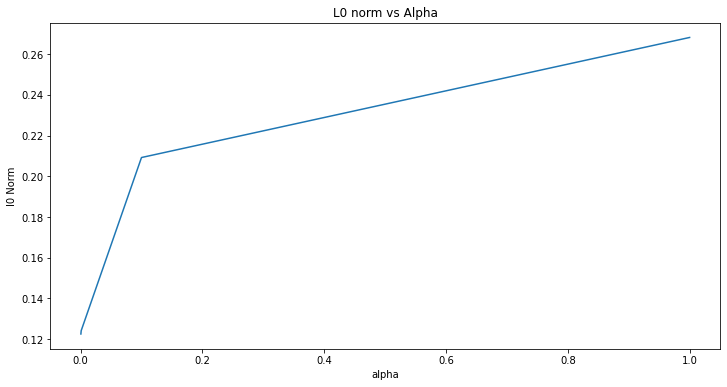

In [14]:
def number_nonzeroes(model):
    model.fit(X_train, y)
    return np.count_nonzero(model.coef_)

    

alph =  [1, 0.1, 0.001, 0.0005]
non_zeroes = [number_nonzeroes(Lasso(alpha=alpha)) for alpha in alph]
non_zeroes_lasso = pd.Series(non_zeroes, index=alph)
cv_lasso.plot(title="L0 norm vs Alpha")
plt.xlabel("alpha")
plt.ylabel("l0 Norm")

5.  Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking).  Be careful not to overfit. What score can you get?  (We will be discussing ensembling more, later in the class, but you can start playing with it now).

In [15]:
from sklearn.model_selection import KFold

models = [LassoCV(alphas=[1, 0.1, 0.001, 0.0005]), RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75])]
kf = KFold(n_splits=len(models))

# train both models on different halves of the dataset
for (train, _), model in zip(kf.split(X_train), models):
    model.fit(X_train[train[0]:train[-1]], y[train[0]:train[-1]])
    
# train the final model with a stack of the original features and model outputs
model_predictions = np.column_stack([m.predict(X_train) for m in models])
new_features = np.c_[X_train, model_predictions]

# get the best alpha for this new step in the pipeline
stacked_model = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75])
stacked_model.fit(new_features, y)

# make predictions and correctly shape output for submission
ensemble_test_preds = np.column_stack([m.predict(X_test) for m in models])
ensemble_test = np.c_[X_test, ensemble_test_preds]

results_ensembled = np.expm1(stacked_model.predict(ensemble_test))
results_ensembled_df = pd.DataFrame(results_ensembled)
results_ensembled_df.columns = ['SalePrice']

results_ensembled_df.index += 1461
results_ensembled_df.index.name = 'Id'

results_ensembled_df.to_csv('./kaggle/results_ensembled.csv')

Results from ensembling and stacking:

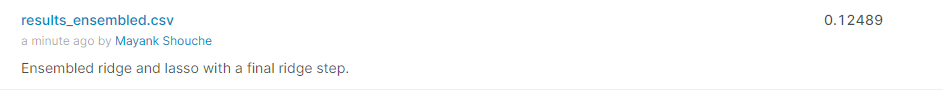

6. Install XGBoost (Gradient Boosting) and train a gradient boosting regression.  What score can you get just from a single XGB? (you will need to optimize over its parameters).  We will discuss boosting and gradient boosting in more detail later.  XGB is a great friend to all goodKagglers!

<AxesSubplot:>

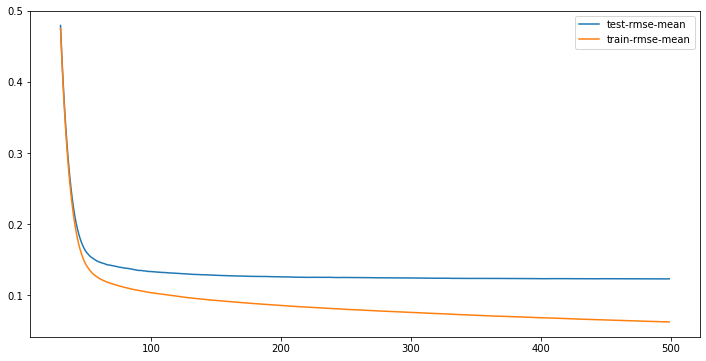

In [16]:
# ! pip3 install xgboost

import xgboost as xgb

# read in data
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()




# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
# num_round = 2
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# preds = bst.predict(dtest)





In [17]:
xgboost_model = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
xgboost_model.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
results_xgb = np.expm1(xgboost_model.predict(X_test))
results_xgb_df = pd.DataFrame(results_xgb)
results_xgb_df.columns = ['SalePrice']

results_xgb_df.index += 1461
results_xgb_df.index.name = 'Id'

results_xgb_df.to_csv('./kaggle/results_xgb.csv')

Kaggle score for XGBoost:

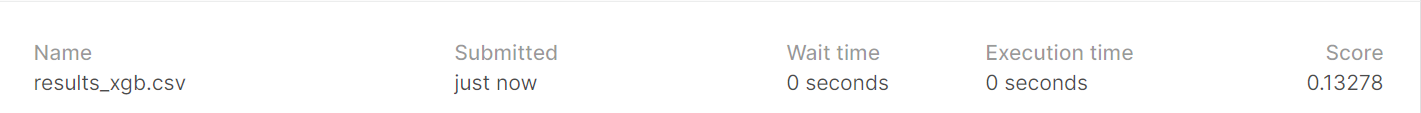

7. Do your best to get the more accurate model.  Try feature engineering and stacking manymodels.  You are allowed to use any public tool in python.  No non-python tools allowed.

In [34]:
# lasso_model = LassoCV(alphas=[1, 0.1, 0.001, 0.0005])

# first_split = int(len(X_train)/2)
# lasso_model.fit(X_train[0:first_split], y[0:first_split])

# first_step_output = lasso_model.predict(X_train[first_split:])
# X_train_2 = np.column_stack((X_train[first_split:], first_step_output))

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV

estimators = [
    ("ridge", RidgeCV()),
    ("elastic", ElasticNetCV())
]

reg = StackingRegressor(estimators=estimators, final_estimator=LassoCV())

reg.fit(X_train, y)

StackingRegressor(estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('elastic', ElasticNetCV())],
                  final_estimator=LassoCV())

In [38]:
results_fin = np.expm1(reg.predict(X_test))
results_fin_df = pd.DataFrame(results_fin)
results_fin_df.columns = ['SalePrice']

results_fin_df.index += 1461
results_fin_df.index.name = 'Id'

results_fin_df.to_csv('./kaggle/results_final.csv')

We tried the following model, which stacked optimized Ridge and ElasticNet models with a final Lasso regressor, but it actually reduced our score.

In [46]:
# lasso_model = LassoCV(alphas=[1, 0.1, 0.001, 0.0005])

# first_split = int(len(X_train)/2)
# lasso_model.fit(X_train[0:first_split], y[0:first_split])

# first_step_output = lasso_model.predict(X_train[first_split:])
# X_train_2 = np.column_stack((X_train[first_split:], first_step_output))

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV

estimators = [
    ("ridge", RidgeCV()),
    ("elastic", ElasticNetCV())
]

reg = StackingRegressor(estimators=estimators, final_estimator=LassoCV())

reg.fit(X_train, y)

results_fin = np.expm1(reg.predict(X_test))
results_fin_df = pd.DataFrame(results_fin)
results_fin_df.columns = ['SalePrice']

results_fin_df.index += 1461
results_fin_df.index.name = 'Id'

results_fin_df.to_csv('./kaggle/results_final.csv')

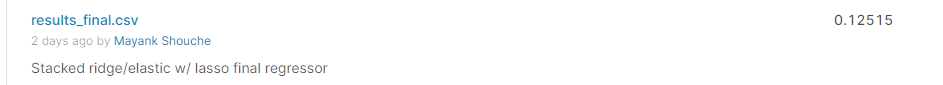

Clearly, we needed some more feature engineering and data cleaning to get a better score. We started by reimporting the data and starting fresh.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [5]:
train = pd.read_csv('./kaggle/train.csv')
test = pd.read_csv('./kaggle/test.csv')


Once again, the target variable is skewed - let's apply a log to it.

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46027076, 10.76769112, 11.07511148, 11.38253184, 11.6899522 ,
        11.99737256, 12.30479292, 12.61221328, 12.91963363, 13.22705399,
        13.53447435]),
 <BarContainer object of 10 artists>)

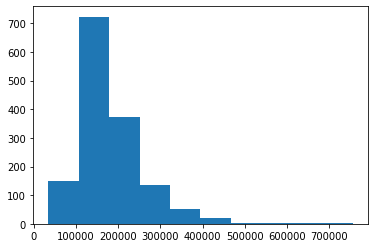

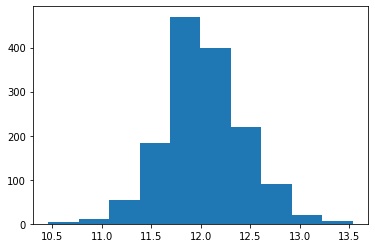

In [6]:
plt.figure(1)
plt.hist(train['SalePrice'])

train['SalePrice'] = np.log1p(train['SalePrice'])

plt.figure(2)
plt.hist(train['SalePrice'])

Get rid of outliers - the given dataset acknowledges that there are two outliers - two homes with large square footage were sold for a low price.

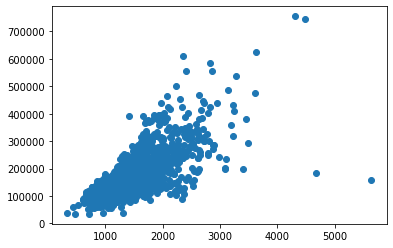

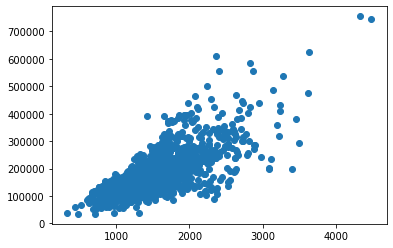

In [7]:
plt.figure(1)
plt.scatter(train['GrLivArea'], np.expm1(train['SalePrice']))

train = train[train.GrLivArea < 4500]

plt.figure(2)
plt.scatter(train['GrLivArea'], np.expm1(train['SalePrice']))

Combine datasets (for now) to work on missing data and some feature engineering.

In [8]:
X_train = train.drop(columns=['SalePrice'])
X_test = test

all_data = pd.concat([X_train.loc[:,'MSSubClass':'SaleCondition'], 
                        X_test.loc[:,'MSSubClass':'SaleCondition']]).reset_index(drop=True)
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Fix missing data & reclassify some columns as categorical that are numerial right now. Credits to [this notebook](https://www.kaggle.com/vaishvik25/top-1-lgb-xbg-stacking) for the columns to be modified.

In [9]:
categorial = ['MSSubClass', 'YrSold', 'MoSold']

for feat in categorial:
    all_data[feat] = all_data[feat].astype(str)



# These columns have most frequent values that make sense to fill nulls with
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr') 
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA') 
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')


# these categorical columns can have their mode filled for nans 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    all_data[col] = all_data[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    all_data[col] = all_data[col].fillna('None')

all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# anything thats categorical should have 'None' instead of NaNs
objects = []
for i in all_data.columns:
    if all_data[i].dtype == object:
        objects.append(i)
all_data.update(all_data[objects].fillna('None'))

# fill missing lot size by the neighborhood median, instead of blindy over the whole dataset median
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# fill 0s for numerical cols
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics.append(i)
all_data.update(all_data[numerics].fillna(0))

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


Fix up skewed columns.

In [10]:

skewed_feats = train[numerics].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
print('Features with high skew: ', skewed_feats)

skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Features with high skew:  LotFrontage       1.541112
LotArea          12.560986
MasVnrArea        2.685003
BsmtFinSF1        0.764002
BsmtFinSF2        4.247550
BsmtUnfSF         0.919955
1stFlrSF          0.886723
2ndFlrSF          0.812121
LowQualFinSF      8.995688
GrLivArea         1.009951
BsmtHalfBath      4.095895
KitchenAbvGr      4.480268
WoodDeckSF        1.544214
OpenPorchSF       2.337421
EnclosedPorch     3.083987
3SsnPorch        10.286510
ScreenPorch       4.114690
PoolArea         15.932532
MiscVal          24.434913
dtype: float64


In [11]:
all_data = pd.get_dummies(all_data)

In [12]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

print(X_train.shape, X_test.shape, y.shape)

(1458, 332) (1459, 332) (1458,)


First, the tried and true approach of a single Lasso regressor (with optimized hyperparams).

In [13]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

results_lasso = np.expm1(model_lasso.predict(X_test))
results_lasso_df = pd.DataFrame(results_lasso)
results_lasso_df.columns = ['SalePrice']

results_lasso_df.index += 1461
results_lasso_df.index.name = 'Id'

results_lasso_df.to_csv('./kaggle/results_final.csv')

Here's what we get:

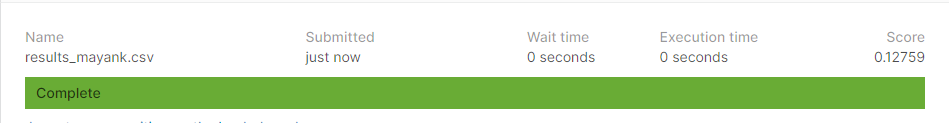

Still not as good as the earlier LassoCV, which is most likely a mathematical anomaly. If we stack models, we might get a better score. XGBRegressor (used for meta-model) parameters from [here](https://www.kaggle.com/vaishvik25/top-1-lgb-xbg-stacking).

In [19]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

kf = KFold(n_splits=10, shuffle=True)

ridge_alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15]
lasso_alphas = [1, 0.75, 0.5, 0.3, 0.1, 0.001, 0.0005]
elastic_alphas = ridge_alphas + lasso_alphas

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alphas, cv=kf))
elastic = make_pipeline(RobustScaler(), ElasticNetCV(alphas=elastic_alphas, cv=kf))

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror',
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

models = [('ridge', ridge), ('lasso', lasso), ('elastic', elastic)]

train_x, test_x, train_y, test_y = train_test_split(X_train, y, random_state=42)

stack = StackingRegressor(estimators=models, final_estimator=xgboost)

stack.fit(train_x, train_y).score(test_x, test_y)

results_stacked = np.expm1(stack.predict(X_test))
results_stacked_df = pd.DataFrame(results_stacked)
results_stacked_df.columns = ['SalePrice']

results_stacked_df.index += 1461
results_stacked_df.index.name = 'Id'

results_stacked_df.to_csv('./kaggle/results_final.csv')



Once again, stacking failed to improve our score (and actually lowered it a little).

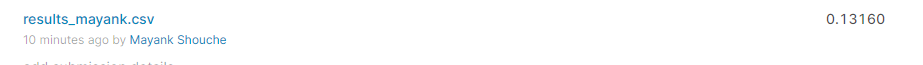


Ultimately, even though we tried things like feature engineering, data cleaning, and stacking and ensembling, we got the best result using a simple LassoCV with a limited amount of data preprocessing. This could be a mathematical anomaly, or simply due to the fact that that model closely approximates the underlying data complexity. 